In [1]:
!git clone https://github.com/CompVis/taming-transformers
%cd taming-transformers

fatal: destination path 'taming-transformers' already exists and is not an empty directory.
/Users/monkojan/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/learning/mindfuel_gen_models/taming-transformers


In [2]:
import sys
sys.path.append(".")

import torch 
import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel

In [3]:
import io
import os, sys
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from IPython.display import display, display_markdown

In [4]:
from torch import Tensor


In [5]:
torch.set_grad_enabled(False)  # disable grad to save memory

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


In [6]:
# download a VQGAN with f=16 (16x compression per spatial dimension) and with a larger codebook (16384 entries)
!mkdir -p logs/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p logs/vqgan_imagenet_f16_16384/configs
!wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt' 
!wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'logs/vqgan_imagenet_f16_16384/configs/model.yaml'

--2022-10-02 21:59:34--  https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/9a9ea020-7ee5-45b6-82e3-9ce68a5f615b/last.ckpt [following]
--2022-10-02 21:59:34--  https://heibox.uni-heidelberg.de/seafhttp/files/9a9ea020-7ee5-45b6-82e3-9ce68a5f615b/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 980092370 (935M) [application/octet-stream]
Saving to: ‘logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’

logs/vqgan_imagenet 100%[===================>] 934.69M  14.4MB/s    in 62s     

2022-10-02 22:00:36 (15.0 MB/s) - ‘logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’ saved [980092370/980092370]

--2022-10-02 22:00:36-- 

In [7]:
def load_config(config_path, display=False):
    config = OmegaConf.load(config_path)
    if display:
        print(yaml.dump(OmegaConf.to_container(config)))
    return config

def load_vqgan(config, ckpt_path=None):
    model = VQModel(**config.model.params)
    if ckpt_path is not None:
        sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
        missing, unexpected = model.load_state_dict(sd, strict=False)
    return model.eval()

def preprocess_vqgan(x):
    x = 2.*x - 1.
    return x

def custom_to_pil(x):
    x = x.detach().cpu()
    x = torch.clamp(x, -1., 1.)
    x = (x + 1.)/2.
    x = x.permute(1,2,0).numpy()
    x = (255*x).astype(np.uint8)
    x = Image.fromarray(x)
    if not x.mode == "RGB":
        x = x.convert("RGB")
    return x

def reconstruct_with_vqgan(x, model):
    # could also use model(x) for reconstruction but use explicit encoding and decoding here
    z, _, [_, _, indices] = model.encode(x)
    print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
    xrec = model.decode(z)
    return xrec

## Load the VQGAN

In [8]:
config16384 = load_config("logs/vqgan_imagenet_f16_16384/configs/model.yaml", display=True)
model16384 = load_vqgan(config16384, ckpt_path="logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(DEVICE)

model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/Users/monkojan/opt/miniconda3/envs/deep_gen/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/monkojan/opt/miniconda3/envs/deep_gen/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [9]:
def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

  
def load_local_image(path):
    return PIL.Image.open(open(path, "r"))


def preprocess(img, target_image_size=256):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img


def stack_reconstructions(input, x0, x1, x2, titles=[]):
    assert input.size == x1.size == x2.size
    w, h = input.size[0], input.size[1]
    img = Image.new("RGB", (5*w, h))
    img.paste(input, (0,0))
    img.paste(x0, (1*w,0))
    img.paste(x1, (2*w,0))
    img.paste(x2, (3*w,0))
    for i, title in enumerate(titles):
        ImageDraw.Draw(img).text((i*w, 0), f'{title}', (255, 255, 255))
    return img

In [10]:
# CONSTANTS

SAMPLE_DIM_TO_ALTER = 11
URL = 'https://heibox.uni-heidelberg.de/f/7bb608381aae4539ba7a/?dl=1'

In [11]:
def get_encoding(x, model):
    h = model.encoder(x)
    # h = model.quant_conv(h)  # What is it for?
    return h


def quantize(h, model):
    h = model.quant_conv(h)
    quant, emb_loss, info = model.quantize(h)
    return quant


def get_quantized_encoding(x, model):
    """Encode + quantize"""
    z, _, [_, _, indices] = model.encode(x)
    print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
    return z


def encoding_pipeline(url, size=320):
    x_vqgan = preprocess(download_image(url), target_image_size=size)
    x_vqgan = x_vqgan.to(DEVICE)
    return get_encoding(preprocess_vqgan(x_vqgan), model16384)

In [12]:
# Interpolate element-wise every cell in latent space

def shift_encoding(z: Tensor, other: Tensor):
    z = z.add(other)
    return z


def find_interpolation_direction(z: Tensor, other: Tensor, n: float = 0.5) -> Tensor:
    direction = torch.sub(other, z)
    direction = torch.mul(direction, n)
    return direction


def simple_find_direction(z: Tensor, pos: int, n=0.1):
    """Dummy direction change"""
    direction = torch.zeros(size=z.size(), device=DEVICE)
    direction_vector = torch.mul(torch.ones(size=(z.size()[1], ), device=DEVICE), n)
    direction[0, :, pos, pos] = direction_vector
    return direction

In [13]:
# Interpolate by mixing cells of latent space

def mix_encoding_stochastic(z: Tensor, other: Tensor, mix_ratio: float = 0.5) -> Tensor:
    """
    Mixes encodings of 2 images.
    Creates a new latent representation by sampling each cell from Bernoulli distribution:
    P(x=image_A) = mix_ratio

    Args:
    z: Image A representation of size (1, latent space dimension (256 by default), w_z, h_z), where w_z == h_z for square images
    other: Image B representation
    mix_ratio: Probability of sampling a cell from Image A representation

    Returns:
    Tensor of mixed representation
    """
    assert z.size() == other.size()

    # generate a tensor of constant probabilities and sample according to it
    probs = torch.mul(torch.ones(size=(z.size()[2], z.size()[3]), device=DEVICE), mix_ratio)
    decisions = torch.bernoulli(probs)  # 1 means sample from Image A
    decisions_expanded = decisions.expand(z.size()[1], -1, -1)  # expand 1s and 0s to the latent space dimension

    # for each latent space cell take Image A or Image B representation according to Bernoulli samples
    samples = torch.where(decisions_expanded > 0, z[0, :, :, :], other[0, :, :, :])
    mixed_z = samples.unsqueeze(0)
    return mixed_z


def mix_encoding_chequered(z: Tensor, other: Tensor) -> Tensor:
    """Mixes encodings of 2 images by creating a chequered pattern of Im A and Im B."""
    pass


def mix_encoding_vertical(z: Tensor, other: Tensor, mix_ratio: float = 0.5) -> Tensor:
    """Mixes encodings of 2 images by creating a vertical border.
    Fills in left part of the representation of size mix_ratio with Im A cells
    and the rest (the right part) with Im B cells."""
    pass


In [14]:
def get_reconstruction(z, model):
    xrec = model.decode(z)
    return xrec


def rec_pipeline_simple(url, model=model16384, size=320, original=False, pos=SAMPLE_DIM_TO_ALTER, n=0.1):

    x_vqgan = preprocess(download_image(url), target_image_size=size).to(DEVICE)
    z = get_encoding(preprocess_vqgan(x_vqgan), model)
    if original:
        z = quantize(z, model)
        xrec = model.decode(z)
        return xrec
    direction = simple_find_direction(z, pos, n)
    z = quantize(z, model)
    z = shift_encoding(z, direction)
    xrec = model.decode(z)
    return xrec


def rec_pipeline_interpolate(url, url_other, model=model16384, size=320, n=0.5):
    """Interpolate between 2 images in latent space before quantization."""
    x = preprocess(download_image(url), target_image_size=size).to(DEVICE)
    z = get_encoding(preprocess_vqgan(x), model)
    x_other = preprocess(download_image(url_other), target_image_size=size).to(DEVICE)
    z_other = get_encoding(preprocess_vqgan(x_other), model)
    direction = find_interpolation_direction(z, z_other, n=n)
    z_inter = shift_encoding(z, direction)
    z_inter = quantize(z_inter, model)
    xrec = model.decode(z_inter)
    return xrec


def rec_pipeline_mix(url, url_other, model=model16384, size=320, mix_ratio=0.5):
    """Mix 2 images in latent space before quantization."""
    x = preprocess(download_image(url), target_image_size=size).to(DEVICE)
    z = get_encoding(preprocess_vqgan(x), model)
    x_other = preprocess(download_image(url_other), target_image_size=size).to(DEVICE)
    z_other = get_encoding(preprocess_vqgan(x_other), model)
    z_mixeed = mix_encoding_stochastic(z, z_other, mix_ratio)
    z_mixeed = quantize(z_mixeed, model)
    xrec = model.decode(z_mixeed)
    return xrec

In [15]:
def stack_reconstructions_general(input, reconstructions, titles=[]):
    assert all([input.size == rec.size for rec in reconstructions])
    w, h = input.size[0], input.size[1]
    num_images = 1 + len(reconstructions)
    img = Image.new("RGB", (num_images*w, h))
    img.paste(input, (0,0))

    for i, rec in enumerate(reconstructions):
        img.paste(rec, ((i+1)*w,0))

    for i, title in enumerate(titles):
        ImageDraw.Draw(img).text((i*w, 0), f'{title}', (255, 255, 255)) # coordinates, text, color, font
    return img

In [16]:
def pipeline(url, model=model16384, size=320, original=False, pos=SAMPLE_DIM_TO_ALTER, n=0.1):
    xrec_orig = rec_pipeline_simple(url=URL, size=384, original=True)
    xrec_altered = rec_pipeline_simple(url=URL, size=384, original=False, pos=pos, n=n)
    return stack_reconstructions_general(input=custom_to_pil(preprocess_vqgan(preprocess(download_image(URL), target_image_size=384)[0])),
                              reconstructions=[custom_to_pil(xrec_orig[0]), custom_to_pil(xrec_altered[0])],
                              titles=["Input", "Reconstruction original", "Reconstruction modified"]
                              )


/var/folders/p5/mnjfwvvx2_ggwp52g0yhxwqh0000gn/T/ipykernel_96985/3477388569.py:19: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
/Users/monkojan/opt/miniconda3/envs/deep_gen/lib/python3.10/site-packages/torchvision/transforms/functional.py:417: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


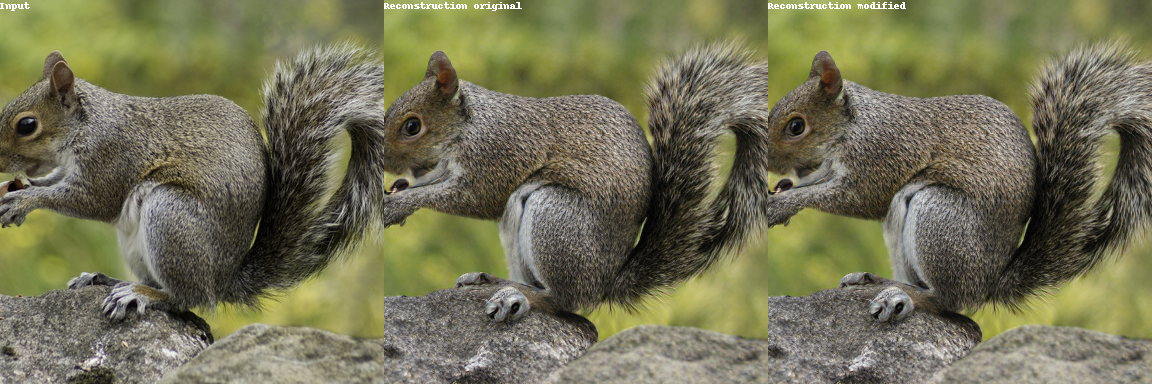

In [17]:
pipeline(URL, pos=1, n=0.2)

In [18]:
# Load data for tests

url_bird_A = 'https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iKIWgaiJUtss/v2/1000x-1.jpg' # penguin
url_bird_B = "https://heibox.uni-heidelberg.de/f/5cfd15de5d104d6fbce4/?dl=1" # parrot
url_building_A = "https://wiki.openstreetmap.org/w/images/6/61/Emptyhouse.jpg"
url_building_B = "https://dynamic-media-cdn.tripadvisor.com/media/photo-o/12/cf/28/3d/bradbury-building.jpg?w=1000&h=-1&s=1"

url_A = url_building_A
url_B = url_bird_B

xrec_orig_A = rec_pipeline_simple(url=url_A, size=384, original=True)
xrec_orig_B = rec_pipeline_simple(url=url_B, size=384, original=True)

/var/folders/p5/mnjfwvvx2_ggwp52g0yhxwqh0000gn/T/ipykernel_96985/3477388569.py:19: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)


# Interpolation with GAN (first stage)

/var/folders/p5/mnjfwvvx2_ggwp52g0yhxwqh0000gn/T/ipykernel_96985/3477388569.py:19: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)


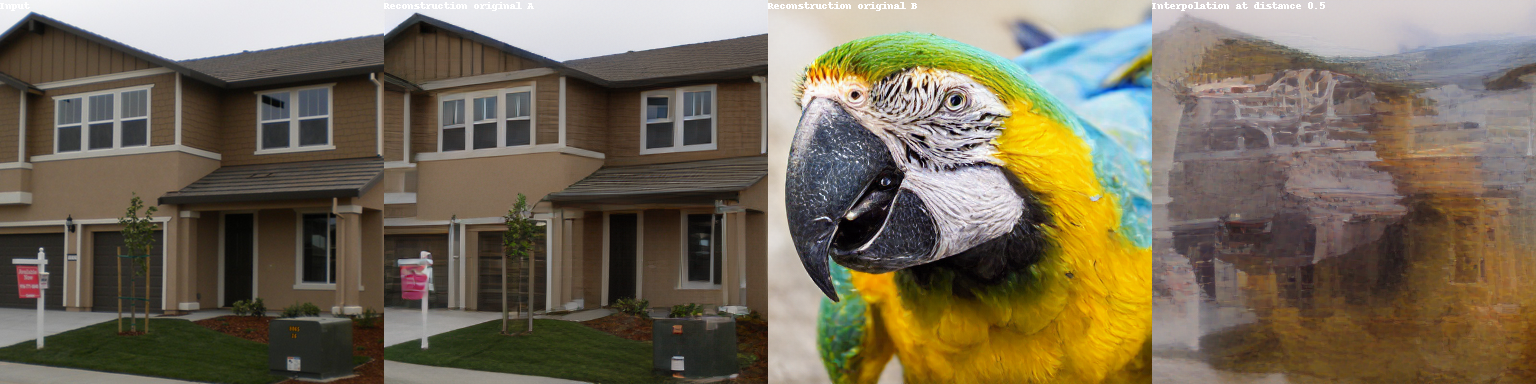

In [19]:
# Interpolation results

n_interpolate = 0.5
xrec_interpolated = rec_pipeline_interpolate(url=url_A, url_other=url_B, size=384, n=n_interpolate)
stack_reconstructions_general(input=custom_to_pil(preprocess_vqgan(preprocess(download_image(url_A), target_image_size=384)[0])),
                              reconstructions=[custom_to_pil(xrec_orig_A[0]), 
                                               custom_to_pil(xrec_orig_B[0]),
                                               custom_to_pil(xrec_interpolated[0])
                                               ],
                              titles=["Input", "Reconstruction original A", "Reconstruction original B", f"Interpolation at distance {n_interpolate}"]
                              )

/var/folders/p5/mnjfwvvx2_ggwp52g0yhxwqh0000gn/T/ipykernel_96985/3477388569.py:19: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)


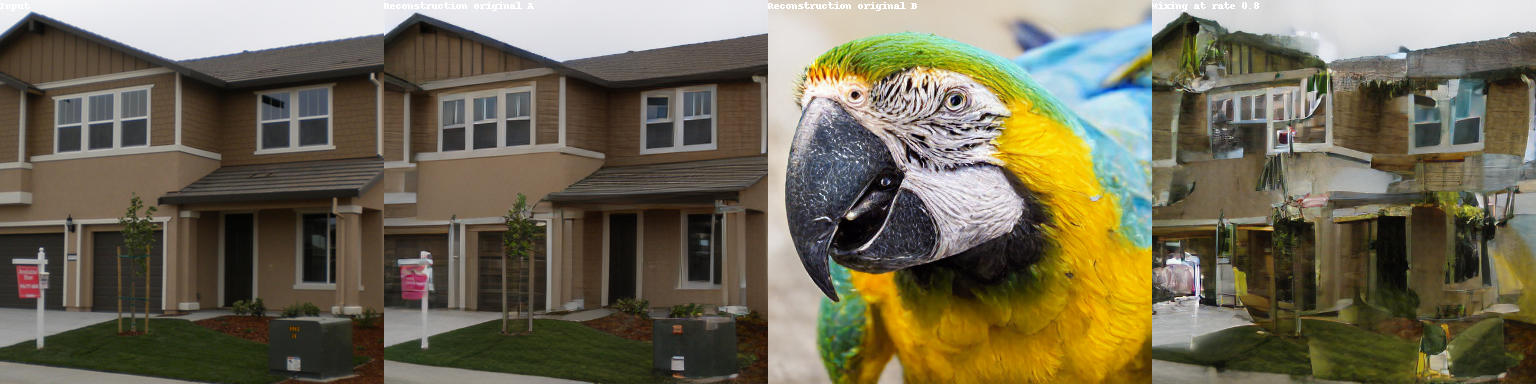

In [20]:
# Mixing results

mix_ratio = 0.8
xrec_mixed = rec_pipeline_mix(url=url_A, url_other=url_B, size=384, mix_ratio=mix_ratio)
stack_reconstructions_general(input=custom_to_pil(preprocess_vqgan(preprocess(download_image(url_A), target_image_size=384)[0])),
                              reconstructions=[custom_to_pil(xrec_orig_A[0]), 
                                               custom_to_pil(xrec_orig_B[0]),
                                               custom_to_pil(xrec_mixed[0])
                                               ],
                              titles=["Input", "Reconstruction original A", "Reconstruction original B", f"Mixing at rate {mix_ratio}"]
                              )

# Interpolation with transformers (second stage)

1. Generate a clue on what we want to show, e.g. a mixed representation of 2 images
2. Generate a new image conditioned on the clue

In [21]:
# %pip install transformers
from taming.models.cond_transformer import Net2NetTransformer

In [22]:
!mkdir -p logs/2020-11-09T13-31-51_sflckr/checkpoints
!wget 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fcheckpoints%2Flast.ckpt&dl=1' -O 'logs/2020-11-09T13-31-51_sflckr/checkpoints/last.ckpt'
!mkdir logs/2020-11-09T13-31-51_sflckr/configs
!wget 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fconfigs%2F2020-11-09T13-31-51-project.yaml&dl=1' -O 'logs/2020-11-09T13-31-51_sflckr/configs/2020-11-09T13-31-51-project.yaml'


--2022-10-02 22:01:04--  https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fcheckpoints%2Flast.ckpt&dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/30eab5b3-cac3-47be-930d-6c0b3928d934/last.ckpt [following]
--2022-10-02 22:01:05--  https://heibox.uni-heidelberg.de/seafhttp/files/30eab5b3-cac3-47be-930d-6c0b3928d934/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 4263525412 (4.0G) [application/octet-stream]
Saving to: ‘logs/2020-11-09T13-31-51_sflckr/checkpoints/last.ckpt’

logs/2020-11-09T13- 100%[===================>]   3.97G  10.4MB/s    in 7m 31s  

2022-10-02 22:08:36 (9.01 MB/s) - ‘logs/2020-11-09T13-31-51_sflckr/checkpoints/last.ckpt’ saved [426352

In [23]:
config_transformers = load_config("logs/2020-11-09T13-31-51_sflckr/configs/2020-11-09T13-31-51-project.yaml", display=True)
# TODO: change model.params.cond_stage_key from segmentation?

data:
  params:
    batch_size: 1
    validation:
      target: taming.data.sflckr.Examples
  target: main.DataModuleFromConfig
model:
  base_learning_rate: 4.5e-06
  params:
    cond_stage_config:
      params:
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          double_z: false
          dropout: 0.0
          in_channels: 182
          num_res_blocks: 2
          out_ch: 182
          resolution: 256
          z_channels: 256
        embed_dim: 256
        image_key: segmentation
        lossconfig:
          target: taming.modules.losses.DummyLoss
        n_embed: 1024
      target: taming.models.vqgan.VQModel
    cond_stage_key: segmentation
    first_stage_config:
      params:
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          doub

In [24]:
model_transformers = Net2NetTransformer(**config_transformers.model.params)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


In [25]:
sd = torch.load("logs/2020-11-09T13-31-51_sflckr/checkpoints/last.ckpt", map_location="cpu")["state_dict"]
missing, unexpected = model_transformers.load_state_dict(sd, strict=False)

In [26]:
if DEVICE == torch.device("cuda:0"):
    model_transformers.cuda().eval()
else:
    model_transformers.eval()

torch.set_grad_enabled(False)

In [27]:
x_A_for_cond = download_image(url_A)
x_A_for_cond = np.array(x_A_for_cond)
print(x_A_for_cond.shape)
# x_A_for_cond = np.eye(182)[x_A_for_cond]
x_A_for_cond = torch.tensor(x_A_for_cond.transpose(2,0,1)[None]).to(dtype=torch.float32, device=DEVICE)
x_A_for_cond.shape

(800, 1280, 3)


torch.Size([1, 3, 800, 1280])

In [28]:
segmentation_path = "data/sflckr_segmentations/norway/25735082181_999927fe5a_b.png"
segmentation = Image.open(segmentation_path)
segmentation = np.array(segmentation)
print(segmentation.shape)
segmentation = np.eye(182)[segmentation]
print(segmentation.shape)
segmentation = torch.tensor(segmentation.transpose(2,0,1)[None]).to(dtype=torch.float32, device=DEVICE)
segmentation.shape

(683, 1024)
(683, 1024, 182)


torch.Size([1, 182, 683, 1024])

In [29]:
c_code, c_indices = model_transformers.encode_to_c(x_A)
print("c_code", c_code.shape, c_code.dtype)
print("c_indices", c_indices.shape, c_indices.dtype)
assert c_code.shape[2]*c_code.shape[3] == c_indices.shape[0]
segmentation_rec = model_transformers.cond_stage_model.decode(c_code)

NameError: name 'x_A' is not defined

In [ ]:
np.eye(2)